In [1]:
#Imports
import logging
import os, random, time, sys
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
import ipdb
import keras
import pandas as pd

sys.path.append('../../../')
import feedforward_robust as ffr

sys.path.append('../../../utils/')
from utils.mnist_corruption import *
from utils.utils_models import *
from utils.utils_analysis import *
from utils.utils_feedforward import *

%load_ext autoreload
%autoreload 2

#Read the counter
ctr_file = "../../counter.txt"
f = open(ctr_file, 'r')
counter = f.readline()
f.close()

counter = 1 + int(counter)
f = open(ctr_file,'w')
f.write('{}'.format(counter))
f.close()
logfile = "../../logs/results_" + str(counter) + ".log"

logger = logging.getLogger("robustness")
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(logfile)
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(logging.StreamHandler())

Using TensorFlow backend.
W0629 17:57:47.241969 4668609984 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/cleverhans/utils_tf.py:341: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.



# Get Raw Training Data

In [2]:
n = 8
n_test = 10000
x_train = np.linspace(-1, 1-(2)/n, n).astype(np.float64)
x_test = np.linspace(-1, 1-(2)/n_test, n_test).astype(np.float64)
x_train = x_train.reshape((n, 1))
x_test = x_test.reshape((n_test, 1))

In [3]:
y_train = np.sign(x_train).astype(np.int)
y_train[y_train==0] = 1
y_train_ogi = y_train.copy()
y_train[y_train==-1] = 0

y_test = np.sign(x_test).astype(np.int)
y_test[y_test==0] = 1
y_test[y_test==-1] = 0

In [4]:
y_train = y_train.flatten()
y_test = y_test.flatten()

In [5]:
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)                                                                                         
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [7]:
y_test[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [8]:
y_test[-10:]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [9]:
def featurize_fourier(X, params_dict, seed=None, p = 0):
    d = params_dict['d']
    p = p/2.
    assert (d-1) % 2 == 0, "d must be odd"
    
    max_r = int((d-1)/2)
    n = len(X)
    A = np.zeros((n, d))
    A[:,0] = 1*(1/np.sqrt(2))
    
    for d_ in range(1,max_r+1):
        A[:,2*(d_-1)+1] = (1./(d_**(p/2))) * np.sin(d_*X*np.pi)
        A[:,2*(d_-1)+2] = (1./(d_**(p/2))) * np.cos(d_*X*np.pi)
    return A

In [10]:
params_dict = {}
params_dict['d'] = 101

In [11]:
phi_x_train = featurize_fourier(x_train.flatten(), params_dict, p = 1.0)
phi_x_test = featurize_fourier(x_test.flatten(), params_dict, p = 1.0)

In [12]:
phi_x_train[5]

array([ 7.07106781e-01,  7.07106781e-01,  7.07106781e-01,  8.40896415e-01,
        5.14900552e-17,  5.37284966e-01, -5.37284966e-01,  8.65956056e-17,
       -7.07106781e-01, -4.72870805e-01, -4.72870805e-01, -6.38943104e-01,
       -1.17371944e-16, -4.34720872e-01,  4.34720872e-01, -1.45635869e-16,
        5.94603558e-01,  4.08248290e-01,  4.08248290e-01,  5.62341325e-01,
        1.72167376e-16,  3.88272678e-01, -3.88272678e-01,  1.97395294e-16,
       -5.37284966e-01, -3.72390989e-01, -3.72390989e-01, -5.16973154e-01,
       -2.21588331e-16, -3.59304112e-01,  3.59304112e-01, -2.44929360e-16,
        5.00000000e-01,  3.48235283e-01,  3.48235283e-01,  4.85491772e-01,
        2.67550175e-16,  3.38685499e-01, -3.38685499e-01,  2.89549859e-16,
       -4.72870805e-01, -3.30316432e-01, -3.30316432e-01, -4.61736631e-01,
       -1.13121438e-15, -3.22888846e-01,  3.22888846e-01, -3.31977990e-16,
        4.51801002e-01,  3.16227766e-01,  3.16227766e-01,  4.42850014e-01,
       -4.34141998e-16,  

# Train neural network

In [13]:
#Configurations
eps_train = None                                                                                                                            
eps_test = None 
pgd_eta, pgd_num_iter = 1e-2, 50
tensorboard_dir = "../tb/"                                                                                                                
weights_dir = "../weights/"
load_weights = False                                                                                                              
load_counter = None                                                                                                            
input_shape = (params_dict['d'],)


sigma = tf.nn.relu 
epochs, reg, lr, batch_size = 1000, 0.00, 3e-4, n # Will have to experiment with learning rate a bit.                                                                                              


In [14]:
#Setup - Dataset stuff
tf.reset_default_graph()
sess = tf.Session()
hidden_sizes = [64, 64, 5]
dataset = ((phi_x_train, y_train), (phi_x_test, y_test))

scope_name = "visualize_one_dim"
if not load_weights:
    with tf.variable_scope(scope_name, reuse = False) as scope:

        logdir = tensorboard_dir + str(counter)

        #Create model
        writer = tf.summary.FileWriter(logdir)
        model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma = sigma)
        sess.run(tf.global_variables_initializer())
        print("Created model successfully. Now going to train")
    
        #Train model
        returned = model.fit(sess, phi_x_train, y_train, training_epochs = epochs, reg_op = reg , lr = lr, batch_size = batch_size, x_test = phi_x_test)
        
        preds_list, feat_list = returned[0], returned[1]
        
        cross_loss, cross_acc = model.evaluate(sess, phi_x_test, y_test)
        print("----Regular loss and accuracy ----")
        print((cross_loss, cross_acc))
        
        
        #featurization = model.get_featurizations(sess, x_test)
        """
        #cross_margins = model.get_pointwise_margin(sess, x_train, y_train)
        cross_weight_norms = model.get_weight_norms(sess)
        print("----- Weight norms ----")
        print(cross_weight_norms)
        
        #Test model - regular, fgsm adv, pgd adv

        
        cross_confidences = model.get_prediction(sess, x_test_flat)
        
        cross_spectral = model.get_spectral_norm(sess)
        """

Initialized instance variables of the robust model class
I0629 17:57:47.995399 4668609984 feedforward_robust.py:32] Initialized instance variables of the robust model class
W0629 17:57:47.996591 4668609984 deprecation_wrapper.py:119] From ../../../feedforward_robust.py:36: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

Created placeholders for x and y
I0629 17:57:48.003613 4668609984 feedforward_robust.py:40] Created placeholders for x and y
W0629 17:57:48.004722 4668609984 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:34: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0629 17:57:48.005342 4668609984 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:34: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0629 17:57:48.006349 4668609984 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:36: The name tf.get_variable

Created model successfully. Now going to train


W0629 17:57:48.675757 4668609984 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/util/tf_should_use.py:193: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
Epoch: 0001    cost: 0.702517152 
I0629 17:57:48.935950 4668609984 feedforward_robust.py:749] Epoch: 0001    cost: 0.702517152 
Accuracy on batch: 0.375000
I0629 17:57:48.937635 4668609984 feedforward_robust.py:750] Accuracy on batch: 0.375000
Epoch: 0002    cost: 0.685916305 
I0629 17:57:48.968336 4668609984 feedforward_robust.py:749] Epoch: 0002    cost: 0.685916305 
Accuracy on batch: 0.500000
I0629 17:57:48.970376 4668609984 feedforward_robust.py:750] Accuracy on batch: 0.500000
Epoch: 0003    cost: 0.669740558 
I0629 17:57:49.006106 4668609984 feedforward_robust.py:749] Epoch: 0003    cost: 0.669740558 
Accuracy on batch: 0.500000
I0629 17:57:49.010267 4668609984 fe

Accuracy on batch: 1.000000
I0629 17:57:49.672864 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0034    cost: 0.423148066 
I0629 17:57:49.692466 4668609984 feedforward_robust.py:749] Epoch: 0034    cost: 0.423148066 
Accuracy on batch: 1.000000
I0629 17:57:49.694018 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0035    cost: 0.416752279 
I0629 17:57:49.713582 4668609984 feedforward_robust.py:749] Epoch: 0035    cost: 0.416752279 
Accuracy on batch: 1.000000
I0629 17:57:49.718006 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0036    cost: 0.410092652 
I0629 17:57:49.737827 4668609984 feedforward_robust.py:749] Epoch: 0036    cost: 0.410092652 
Accuracy on batch: 1.000000
I0629 17:57:49.739181 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0037    cost: 0.403357059 
I0629 17:57:49.758021 4668609984 feedforward_robust.py:749] Epoch: 0037    cost: 0.403357059 
Accuracy on batch: 1.000

I0629 17:57:50.367552 4668609984 feedforward_robust.py:749] Epoch: 0067    cost: 0.259704709 
Accuracy on batch: 1.000000
I0629 17:57:50.369750 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0068    cost: 0.257000595 
I0629 17:57:50.390103 4668609984 feedforward_robust.py:749] Epoch: 0068    cost: 0.257000595 
Accuracy on batch: 1.000000
I0629 17:57:50.392224 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0069    cost: 0.254375935 
I0629 17:57:50.410628 4668609984 feedforward_robust.py:749] Epoch: 0069    cost: 0.254375935 
Accuracy on batch: 1.000000
I0629 17:57:50.412936 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0070    cost: 0.251926094 
I0629 17:57:50.430544 4668609984 feedforward_robust.py:749] Epoch: 0070    cost: 0.251926094 
Accuracy on batch: 1.000000
I0629 17:57:50.431869 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0071    cost: 0.249569088 
I0629 17:57:50.448703 46

Epoch: 0101    cost: 0.203286558 
I0629 17:57:51.036828 4668609984 feedforward_robust.py:749] Epoch: 0101    cost: 0.203286558 
Accuracy on batch: 1.000000
I0629 17:57:51.039090 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0102    cost: 0.202339262 
I0629 17:57:51.055428 4668609984 feedforward_robust.py:749] Epoch: 0102    cost: 0.202339262 
Accuracy on batch: 1.000000
I0629 17:57:51.058280 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0103    cost: 0.201403826 
I0629 17:57:51.076720 4668609984 feedforward_robust.py:749] Epoch: 0103    cost: 0.201403826 
Accuracy on batch: 1.000000
I0629 17:57:51.078214 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0104    cost: 0.200487345 
I0629 17:57:51.094146 4668609984 feedforward_robust.py:749] Epoch: 0104    cost: 0.200487345 
Accuracy on batch: 1.000000
I0629 17:57:51.096474 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0105    cost: 0.1

I0629 17:57:51.710169 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0135    cost: 0.180620596 
I0629 17:57:51.730180 4668609984 feedforward_robust.py:749] Epoch: 0135    cost: 0.180620596 
Accuracy on batch: 1.000000
I0629 17:57:51.731386 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0136    cost: 0.180176839 
I0629 17:57:51.750070 4668609984 feedforward_robust.py:749] Epoch: 0136    cost: 0.180176839 
Accuracy on batch: 1.000000
I0629 17:57:51.751549 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0137    cost: 0.179734111 
I0629 17:57:51.769178 4668609984 feedforward_robust.py:749] Epoch: 0137    cost: 0.179734111 
Accuracy on batch: 1.000000
I0629 17:57:51.770886 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0138    cost: 0.179298669 
I0629 17:57:51.787173 4668609984 feedforward_robust.py:749] Epoch: 0138    cost: 0.179298669 
Accuracy on batch: 1.000000
I0629 17:57:51.788859 46

Accuracy on batch: 1.000000
I0629 17:57:52.390464 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0169    cost: 0.169319212 
I0629 17:57:52.410926 4668609984 feedforward_robust.py:749] Epoch: 0169    cost: 0.169319212 
Accuracy on batch: 1.000000
I0629 17:57:52.412825 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0170    cost: 0.169081867 
I0629 17:57:52.432126 4668609984 feedforward_robust.py:749] Epoch: 0170    cost: 0.169081867 
Accuracy on batch: 1.000000
I0629 17:57:52.433355 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0171    cost: 0.168853223 
I0629 17:57:52.451390 4668609984 feedforward_robust.py:749] Epoch: 0171    cost: 0.168853223 
Accuracy on batch: 1.000000
I0629 17:57:52.454146 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0172    cost: 0.168627143 
I0629 17:57:52.470985 4668609984 feedforward_robust.py:749] Epoch: 0172    cost: 0.168627143 
Accuracy on batch: 1.000

I0629 17:57:53.062679 4668609984 feedforward_robust.py:749] Epoch: 0202    cost: 0.151874200 
Accuracy on batch: 1.000000
I0629 17:57:53.063960 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0203    cost: 0.149454415 
I0629 17:57:53.083766 4668609984 feedforward_robust.py:749] Epoch: 0203    cost: 0.149454415 
Accuracy on batch: 1.000000
I0629 17:57:53.086807 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0204    cost: 0.146937147 
I0629 17:57:53.102643 4668609984 feedforward_robust.py:749] Epoch: 0204    cost: 0.146937147 
Accuracy on batch: 1.000000
I0629 17:57:53.105036 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0205    cost: 0.144389421 
I0629 17:57:53.122251 4668609984 feedforward_robust.py:749] Epoch: 0205    cost: 0.144389421 
Accuracy on batch: 1.000000
I0629 17:57:53.124667 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0206    cost: 0.141841084 
I0629 17:57:53.141045 46

Epoch: 0236    cost: 0.069084801 
I0629 17:57:53.839878 4668609984 feedforward_robust.py:749] Epoch: 0236    cost: 0.069084801 
Accuracy on batch: 1.000000
I0629 17:57:53.843078 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0237    cost: 0.065974556 
I0629 17:57:53.865093 4668609984 feedforward_robust.py:749] Epoch: 0237    cost: 0.065974556 
Accuracy on batch: 1.000000
I0629 17:57:53.866993 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0238    cost: 0.062918805 
I0629 17:57:53.886842 4668609984 feedforward_robust.py:749] Epoch: 0238    cost: 0.062918805 
Accuracy on batch: 1.000000
I0629 17:57:53.888247 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0239    cost: 0.059950702 
I0629 17:57:53.905133 4668609984 feedforward_robust.py:749] Epoch: 0239    cost: 0.059950702 
Accuracy on batch: 1.000000
I0629 17:57:53.906912 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0240    cost: 0.0

I0629 17:57:54.606553 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0270    cost: 0.017719369 
I0629 17:57:54.624886 4668609984 feedforward_robust.py:749] Epoch: 0270    cost: 0.017719369 
Accuracy on batch: 1.000000
I0629 17:57:54.627490 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0271    cost: 0.017166110 
I0629 17:57:54.652946 4668609984 feedforward_robust.py:749] Epoch: 0271    cost: 0.017166110 
Accuracy on batch: 1.000000
I0629 17:57:54.654953 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0272    cost: 0.016647343 
I0629 17:57:54.674745 4668609984 feedforward_robust.py:749] Epoch: 0272    cost: 0.016647343 
Accuracy on batch: 1.000000
I0629 17:57:54.676580 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0273    cost: 0.016146515 
I0629 17:57:54.690373 4668609984 feedforward_robust.py:749] Epoch: 0273    cost: 0.016146515 
Accuracy on batch: 1.000000
I0629 17:57:54.691484 46

Accuracy on batch: 1.000000
I0629 17:57:55.331722 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0304    cost: 0.007691201 
I0629 17:57:55.352583 4668609984 feedforward_robust.py:749] Epoch: 0304    cost: 0.007691201 
Accuracy on batch: 1.000000
I0629 17:57:55.354043 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0305    cost: 0.007553853 
I0629 17:57:55.372193 4668609984 feedforward_robust.py:749] Epoch: 0305    cost: 0.007553853 
Accuracy on batch: 1.000000
I0629 17:57:55.374621 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0306    cost: 0.007413490 
I0629 17:57:55.394873 4668609984 feedforward_robust.py:749] Epoch: 0306    cost: 0.007413490 
Accuracy on batch: 1.000000
I0629 17:57:55.396209 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0307    cost: 0.007279889 
I0629 17:57:55.416197 4668609984 feedforward_robust.py:749] Epoch: 0307    cost: 0.007279889 
Accuracy on batch: 1.000

I0629 17:57:56.035021 4668609984 feedforward_robust.py:749] Epoch: 0337    cost: 0.004525486 
Accuracy on batch: 1.000000
I0629 17:57:56.038196 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0338    cost: 0.004462274 
I0629 17:57:56.058010 4668609984 feedforward_robust.py:749] Epoch: 0338    cost: 0.004462274 
Accuracy on batch: 1.000000
I0629 17:57:56.059329 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0339    cost: 0.004400021 
I0629 17:57:56.075609 4668609984 feedforward_robust.py:749] Epoch: 0339    cost: 0.004400021 
Accuracy on batch: 1.000000
I0629 17:57:56.077039 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0340    cost: 0.004338774 
I0629 17:57:56.095166 4668609984 feedforward_robust.py:749] Epoch: 0340    cost: 0.004338774 
Accuracy on batch: 1.000000
I0629 17:57:56.098138 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0341    cost: 0.004278518 
I0629 17:57:56.117766 46

Epoch: 0371    cost: 0.002993834 
I0629 17:57:56.772396 4668609984 feedforward_robust.py:749] Epoch: 0371    cost: 0.002993834 
Accuracy on batch: 1.000000
I0629 17:57:56.774315 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0372    cost: 0.002962798 
I0629 17:57:56.795952 4668609984 feedforward_robust.py:749] Epoch: 0372    cost: 0.002962798 
Accuracy on batch: 1.000000
I0629 17:57:56.797629 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0373    cost: 0.002932796 
I0629 17:57:56.815726 4668609984 feedforward_robust.py:749] Epoch: 0373    cost: 0.002932796 
Accuracy on batch: 1.000000
I0629 17:57:56.817571 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0374    cost: 0.002903398 
I0629 17:57:56.835887 4668609984 feedforward_robust.py:749] Epoch: 0374    cost: 0.002903398 
Accuracy on batch: 1.000000
I0629 17:57:56.837203 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0375    cost: 0.0

I0629 17:57:57.503957 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0405    cost: 0.002188059 
I0629 17:57:57.527212 4668609984 feedforward_robust.py:749] Epoch: 0405    cost: 0.002188059 
Accuracy on batch: 1.000000
I0629 17:57:57.529844 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0406    cost: 0.002170091 
I0629 17:57:57.549501 4668609984 feedforward_robust.py:749] Epoch: 0406    cost: 0.002170091 
Accuracy on batch: 1.000000
I0629 17:57:57.552337 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0407    cost: 0.002152389 
I0629 17:57:57.571024 4668609984 feedforward_robust.py:749] Epoch: 0407    cost: 0.002152389 
Accuracy on batch: 1.000000
I0629 17:57:57.573076 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0408    cost: 0.002134983 
I0629 17:57:57.592733 4668609984 feedforward_robust.py:749] Epoch: 0408    cost: 0.002134983 
Accuracy on batch: 1.000000
I0629 17:57:57.593998 46

Accuracy on batch: 1.000000
I0629 17:57:58.229843 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0439    cost: 0.001691645 
I0629 17:57:58.247905 4668609984 feedforward_robust.py:749] Epoch: 0439    cost: 0.001691645 
Accuracy on batch: 1.000000
I0629 17:57:58.249051 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0440    cost: 0.001679910 
I0629 17:57:58.263888 4668609984 feedforward_robust.py:749] Epoch: 0440    cost: 0.001679910 
Accuracy on batch: 1.000000
I0629 17:57:58.265200 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0441    cost: 0.001668205 
I0629 17:57:58.283449 4668609984 feedforward_robust.py:749] Epoch: 0441    cost: 0.001668205 
Accuracy on batch: 1.000000
I0629 17:57:58.285463 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0442    cost: 0.001656885 
I0629 17:57:58.303658 4668609984 feedforward_robust.py:749] Epoch: 0442    cost: 0.001656885 
Accuracy on batch: 1.000

I0629 17:57:58.954677 4668609984 feedforward_robust.py:749] Epoch: 0472    cost: 0.001359302 
Accuracy on batch: 1.000000
I0629 17:57:58.956161 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0473    cost: 0.001350784 
I0629 17:57:58.973643 4668609984 feedforward_robust.py:749] Epoch: 0473    cost: 0.001350784 
Accuracy on batch: 1.000000
I0629 17:57:58.978635 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0474    cost: 0.001342250 
I0629 17:57:58.998837 4668609984 feedforward_robust.py:749] Epoch: 0474    cost: 0.001342250 
Accuracy on batch: 1.000000
I0629 17:57:59.000229 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0475    cost: 0.001333762 
I0629 17:57:59.023483 4668609984 feedforward_robust.py:749] Epoch: 0475    cost: 0.001333762 
Accuracy on batch: 1.000000
I0629 17:57:59.026639 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0476    cost: 0.001325317 
I0629 17:57:59.046704 46

Epoch: 0506    cost: 0.001114771 
I0629 17:57:59.766839 4668609984 feedforward_robust.py:749] Epoch: 0506    cost: 0.001114771 
Accuracy on batch: 1.000000
I0629 17:57:59.769352 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0507    cost: 0.001108704 
I0629 17:57:59.795150 4668609984 feedforward_robust.py:749] Epoch: 0507    cost: 0.001108704 
Accuracy on batch: 1.000000
I0629 17:57:59.797551 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0508    cost: 0.001102770 
I0629 17:57:59.824903 4668609984 feedforward_robust.py:749] Epoch: 0508    cost: 0.001102770 
Accuracy on batch: 1.000000
I0629 17:57:59.829069 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0509    cost: 0.001096820 
I0629 17:57:59.847536 4668609984 feedforward_robust.py:749] Epoch: 0509    cost: 0.001096820 
Accuracy on batch: 1.000000
I0629 17:57:59.848695 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0510    cost: 0.0

I0629 17:58:00.501183 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0540    cost: 0.000929805 
I0629 17:58:00.520442 4668609984 feedforward_robust.py:749] Epoch: 0540    cost: 0.000929805 
Accuracy on batch: 1.000000
I0629 17:58:00.522104 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0541    cost: 0.000925000 
I0629 17:58:00.543095 4668609984 feedforward_robust.py:749] Epoch: 0541    cost: 0.000925000 
Accuracy on batch: 1.000000
I0629 17:58:00.545754 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0542    cost: 0.000920298 
I0629 17:58:00.567761 4668609984 feedforward_robust.py:749] Epoch: 0542    cost: 0.000920298 
Accuracy on batch: 1.000000
I0629 17:58:00.569348 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0543    cost: 0.000915656 
I0629 17:58:00.588958 4668609984 feedforward_robust.py:749] Epoch: 0543    cost: 0.000915656 
Accuracy on batch: 1.000000
I0629 17:58:00.590317 46

Accuracy on batch: 1.000000
I0629 17:58:01.214609 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0574    cost: 0.000787333 
I0629 17:58:01.235237 4668609984 feedforward_robust.py:749] Epoch: 0574    cost: 0.000787333 
Accuracy on batch: 1.000000
I0629 17:58:01.237758 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0575    cost: 0.000783568 
I0629 17:58:01.256901 4668609984 feedforward_robust.py:749] Epoch: 0575    cost: 0.000783568 
Accuracy on batch: 1.000000
I0629 17:58:01.258840 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0576    cost: 0.000779877 
I0629 17:58:01.279255 4668609984 feedforward_robust.py:749] Epoch: 0576    cost: 0.000779877 
Accuracy on batch: 1.000000
I0629 17:58:01.281415 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0577    cost: 0.000776231 
I0629 17:58:01.299766 4668609984 feedforward_robust.py:749] Epoch: 0577    cost: 0.000776231 
Accuracy on batch: 1.000

I0629 17:58:01.947906 4668609984 feedforward_robust.py:749] Epoch: 0607    cost: 0.000675036 
Accuracy on batch: 1.000000
I0629 17:58:01.949537 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0608    cost: 0.000671985 
I0629 17:58:01.968300 4668609984 feedforward_robust.py:749] Epoch: 0608    cost: 0.000671985 
Accuracy on batch: 1.000000
I0629 17:58:01.970175 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0609    cost: 0.000668993 
I0629 17:58:01.990756 4668609984 feedforward_robust.py:749] Epoch: 0609    cost: 0.000668993 
Accuracy on batch: 1.000000
I0629 17:58:01.992439 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0610    cost: 0.000665971 
I0629 17:58:02.008111 4668609984 feedforward_robust.py:749] Epoch: 0610    cost: 0.000665971 
Accuracy on batch: 1.000000
I0629 17:58:02.009768 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0611    cost: 0.000663009 
I0629 17:58:02.028279 46

Epoch: 0641    cost: 0.000583098 
I0629 17:58:02.665328 4668609984 feedforward_robust.py:749] Epoch: 0641    cost: 0.000583098 
Accuracy on batch: 1.000000
I0629 17:58:02.667725 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0642    cost: 0.000580687 
I0629 17:58:02.685145 4668609984 feedforward_robust.py:749] Epoch: 0642    cost: 0.000580687 
Accuracy on batch: 1.000000
I0629 17:58:02.687135 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0643    cost: 0.000578349 
I0629 17:58:02.707198 4668609984 feedforward_robust.py:749] Epoch: 0643    cost: 0.000578349 
Accuracy on batch: 1.000000
I0629 17:58:02.708857 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0644    cost: 0.000575952 
I0629 17:58:02.725582 4668609984 feedforward_robust.py:749] Epoch: 0644    cost: 0.000575952 
Accuracy on batch: 1.000000
I0629 17:58:02.728523 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0645    cost: 0.0

I0629 17:58:03.351715 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0675    cost: 0.000509833 
I0629 17:58:03.368952 4668609984 feedforward_robust.py:749] Epoch: 0675    cost: 0.000509833 
Accuracy on batch: 1.000000
I0629 17:58:03.370903 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0676    cost: 0.000507913 
I0629 17:58:03.388812 4668609984 feedforward_robust.py:749] Epoch: 0676    cost: 0.000507913 
Accuracy on batch: 1.000000
I0629 17:58:03.391798 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0677    cost: 0.000506022 
I0629 17:58:03.410578 4668609984 feedforward_robust.py:749] Epoch: 0677    cost: 0.000506022 
Accuracy on batch: 1.000000
I0629 17:58:03.412651 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0678    cost: 0.000504086 
I0629 17:58:03.432352 4668609984 feedforward_robust.py:749] Epoch: 0678    cost: 0.000504086 
Accuracy on batch: 1.000000
I0629 17:58:03.434338 46

Accuracy on batch: 1.000000
I0629 17:58:04.059059 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0709    cost: 0.000450155 
I0629 17:58:04.078734 4668609984 feedforward_robust.py:749] Epoch: 0709    cost: 0.000450155 
Accuracy on batch: 1.000000
I0629 17:58:04.081072 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0710    cost: 0.000448606 
I0629 17:58:04.099320 4668609984 feedforward_robust.py:749] Epoch: 0710    cost: 0.000448606 
Accuracy on batch: 1.000000
I0629 17:58:04.101042 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0711    cost: 0.000446983 
I0629 17:58:04.119661 4668609984 feedforward_robust.py:749] Epoch: 0711    cost: 0.000446983 
Accuracy on batch: 1.000000
I0629 17:58:04.121032 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0712    cost: 0.000445435 
I0629 17:58:04.138692 4668609984 feedforward_robust.py:749] Epoch: 0712    cost: 0.000445435 
Accuracy on batch: 1.000

I0629 17:58:04.756338 4668609984 feedforward_robust.py:749] Epoch: 0742    cost: 0.000402057 
Accuracy on batch: 1.000000
I0629 17:58:04.758583 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0743    cost: 0.000400746 
I0629 17:58:04.778120 4668609984 feedforward_robust.py:749] Epoch: 0743    cost: 0.000400746 
Accuracy on batch: 1.000000
I0629 17:58:04.781086 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0744    cost: 0.000399391 
I0629 17:58:04.804415 4668609984 feedforward_robust.py:749] Epoch: 0744    cost: 0.000399391 
Accuracy on batch: 1.000000
I0629 17:58:04.806477 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0745    cost: 0.000398095 
I0629 17:58:04.825608 4668609984 feedforward_robust.py:749] Epoch: 0745    cost: 0.000398095 
Accuracy on batch: 1.000000
I0629 17:58:04.827519 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0746    cost: 0.000396755 
I0629 17:58:04.848186 46

Epoch: 0776    cost: 0.000358973 
I0629 17:58:05.477362 4668609984 feedforward_robust.py:749] Epoch: 0776    cost: 0.000358973 
Accuracy on batch: 1.000000
I0629 17:58:05.479759 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0777    cost: 0.000357796 
I0629 17:58:05.497522 4668609984 feedforward_robust.py:749] Epoch: 0777    cost: 0.000357796 
Accuracy on batch: 1.000000
I0629 17:58:05.500569 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0778    cost: 0.000356605 
I0629 17:58:05.520436 4668609984 feedforward_robust.py:749] Epoch: 0778    cost: 0.000356605 
Accuracy on batch: 1.000000
I0629 17:58:05.521651 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0779    cost: 0.000355428 
I0629 17:58:05.539422 4668609984 feedforward_robust.py:749] Epoch: 0779    cost: 0.000355428 
Accuracy on batch: 1.000000
I0629 17:58:05.541519 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0780    cost: 0.0

I0629 17:58:06.169754 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0810    cost: 0.000322156 
I0629 17:58:06.189436 4668609984 feedforward_robust.py:749] Epoch: 0810    cost: 0.000322156 
Accuracy on batch: 1.000000
I0629 17:58:06.191338 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0811    cost: 0.000321159 
I0629 17:58:06.209610 4668609984 feedforward_robust.py:749] Epoch: 0811    cost: 0.000321159 
Accuracy on batch: 1.000000
I0629 17:58:06.212846 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0812    cost: 0.000320190 
I0629 17:58:06.229903 4668609984 feedforward_robust.py:749] Epoch: 0812    cost: 0.000320190 
Accuracy on batch: 1.000000
I0629 17:58:06.231956 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0813    cost: 0.000319222 
I0629 17:58:06.249748 4668609984 feedforward_robust.py:749] Epoch: 0813    cost: 0.000319222 
Accuracy on batch: 1.000000
I0629 17:58:06.251528 46

Accuracy on batch: 1.000000
I0629 17:58:06.889142 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0844    cost: 0.000291222 
I0629 17:58:06.909794 4668609984 feedforward_robust.py:749] Epoch: 0844    cost: 0.000291222 
Accuracy on batch: 1.000000
I0629 17:58:06.911949 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0845    cost: 0.000290402 
I0629 17:58:06.931399 4668609984 feedforward_robust.py:749] Epoch: 0845    cost: 0.000290402 
Accuracy on batch: 1.000000
I0629 17:58:06.933287 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0846    cost: 0.000289538 
I0629 17:58:06.952430 4668609984 feedforward_robust.py:749] Epoch: 0846    cost: 0.000289538 
Accuracy on batch: 1.000000
I0629 17:58:06.954360 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0847    cost: 0.000288749 
I0629 17:58:06.972358 4668609984 feedforward_robust.py:749] Epoch: 0847    cost: 0.000288749 
Accuracy on batch: 1.000

I0629 17:58:07.633679 4668609984 feedforward_robust.py:749] Epoch: 0877    cost: 0.000265528 
Accuracy on batch: 1.000000
I0629 17:58:07.635921 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0878    cost: 0.000264798 
I0629 17:58:07.655045 4668609984 feedforward_robust.py:749] Epoch: 0878    cost: 0.000264798 
Accuracy on batch: 1.000000
I0629 17:58:07.657542 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0879    cost: 0.000264054 
I0629 17:58:07.679133 4668609984 feedforward_robust.py:749] Epoch: 0879    cost: 0.000264054 
Accuracy on batch: 1.000000
I0629 17:58:07.681567 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0880    cost: 0.000263368 
I0629 17:58:07.701240 4668609984 feedforward_robust.py:749] Epoch: 0880    cost: 0.000263368 
Accuracy on batch: 1.000000
I0629 17:58:07.703316 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0881    cost: 0.000262639 
I0629 17:58:07.724114 46

Epoch: 0911    cost: 0.000242590 
I0629 17:58:08.381311 4668609984 feedforward_robust.py:749] Epoch: 0911    cost: 0.000242590 
Accuracy on batch: 1.000000
I0629 17:58:08.384386 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0912    cost: 0.000241979 
I0629 17:58:08.405239 4668609984 feedforward_robust.py:749] Epoch: 0912    cost: 0.000241979 
Accuracy on batch: 1.000000
I0629 17:58:08.406476 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0913    cost: 0.000241353 
I0629 17:58:08.430011 4668609984 feedforward_robust.py:749] Epoch: 0913    cost: 0.000241353 
Accuracy on batch: 1.000000
I0629 17:58:08.432418 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0914    cost: 0.000240713 
I0629 17:58:08.453487 4668609984 feedforward_robust.py:749] Epoch: 0914    cost: 0.000240713 
Accuracy on batch: 1.000000
I0629 17:58:08.454766 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0915    cost: 0.0

I0629 17:58:09.152026 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0945    cost: 0.000222629 
I0629 17:58:09.171329 4668609984 feedforward_robust.py:749] Epoch: 0945    cost: 0.000222629 
Accuracy on batch: 1.000000
I0629 17:58:09.172437 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0946    cost: 0.000222063 
I0629 17:58:09.194653 4668609984 feedforward_robust.py:749] Epoch: 0946    cost: 0.000222063 
Accuracy on batch: 1.000000
I0629 17:58:09.198935 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0947    cost: 0.000221512 
I0629 17:58:09.216979 4668609984 feedforward_robust.py:749] Epoch: 0947    cost: 0.000221512 
Accuracy on batch: 1.000000
I0629 17:58:09.218617 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0948    cost: 0.000220991 
I0629 17:58:09.250247 4668609984 feedforward_robust.py:749] Epoch: 0948    cost: 0.000220991 
Accuracy on batch: 1.000000
I0629 17:58:09.252185 46

Accuracy on batch: 1.000000
I0629 17:58:09.903247 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0979    cost: 0.000205037 
I0629 17:58:09.925127 4668609984 feedforward_robust.py:749] Epoch: 0979    cost: 0.000205037 
Accuracy on batch: 1.000000
I0629 17:58:09.930242 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0980    cost: 0.000204531 
I0629 17:58:09.953501 4668609984 feedforward_robust.py:749] Epoch: 0980    cost: 0.000204531 
Accuracy on batch: 1.000000
I0629 17:58:09.957033 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0981    cost: 0.000204039 
I0629 17:58:09.975507 4668609984 feedforward_robust.py:749] Epoch: 0981    cost: 0.000204039 
Accuracy on batch: 1.000000
I0629 17:58:09.979643 4668609984 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0982    cost: 0.000203577 
I0629 17:58:09.999691 4668609984 feedforward_robust.py:749] Epoch: 0982    cost: 0.000203577 
Accuracy on batch: 1.000

----Regular loss and accuracy ----
(1.0570709, 0.5037)


In [15]:
feat_list = np.array(feat_list)
preds_list = np.array(preds_list)

In [16]:
feat_list.shape

(1000, 10000, 5)

# Processing preds and plotting

In [17]:
def flatten_single_pred(preds_single_epoch):
    preds_new = [preds[1] - preds[0] for preds in preds_single_epoch]
    return preds_new

In [18]:
preds_list_flat = [flatten_single_pred(pse) for pse in preds_list]

In [19]:
preds_list_flat = np.array(preds_list_flat)
preds_list_flat.shape

(1000, 10000)

In [20]:
preds_means = np.mean(np.abs(preds_list_flat), axis = 1)
preds_means.shape

(1000,)

In [21]:
preds_means

array([0.41038218, 0.40716344, 0.4042185 , 0.40147895, 0.40108943,
       0.4020479 , 0.40444237, 0.40768102, 0.41154727, 0.41589755,
       0.42075536, 0.42615786, 0.43143234, 0.43653965, 0.44125327,
       0.4455957 , 0.4496073 , 0.4538093 , 0.45830578, 0.46323618,
       0.46875048, 0.47426367, 0.47969726, 0.48522565, 0.4914039 ,
       0.49770176, 0.5045733 , 0.51205266, 0.52031386, 0.529092  ,
       0.5382714 , 0.54772216, 0.5578809 , 0.56874275, 0.58045095,
       0.5928354 , 0.6057768 , 0.6189886 , 0.6326376 , 0.6464743 ,
       0.66079605, 0.67571884, 0.6902538 , 0.70449686, 0.7183295 ,
       0.73229206, 0.74671066, 0.7614561 , 0.7760886 , 0.79110026,
       0.8060211 , 0.820567  , 0.83480585, 0.84762394, 0.8595572 ,
       0.87078077, 0.8805149 , 0.8904162 , 0.9004545 , 0.9110643 ,
       0.92197627, 0.9327457 , 0.9434796 , 0.95378107, 0.9644326 ,
       0.9752494 , 0.98593855, 0.99632245, 1.0066364 , 1.015539  ,
       1.0246463 , 1.0338157 , 1.0431219 , 1.0522475 , 1.06130

In [22]:
final_preds = preds_list_flat[-1]
final_preds.shape

(10000,)

In [23]:
indices = np.arange(0, 100, 20)

In [24]:
indices

array([ 0, 20, 40, 60, 80])

In [25]:
indices_two = np.arange(100, 1000, 100)

In [26]:
indices = np.hstack((indices, indices_two))

In [27]:
preds_list_smaller = preds_list_flat[indices]
preds_list_smaller.shape

(14, 10000)

In [28]:
x_train.shape

(8, 1)

In [29]:
y_train_ogi.shape

(8, 1)

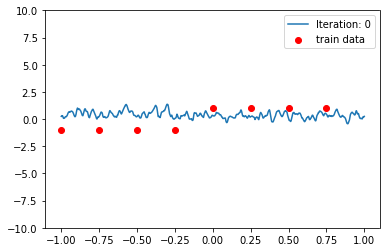

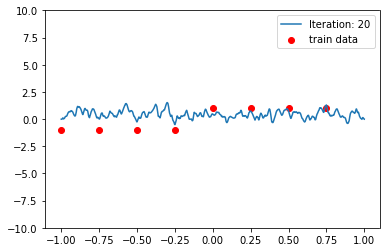

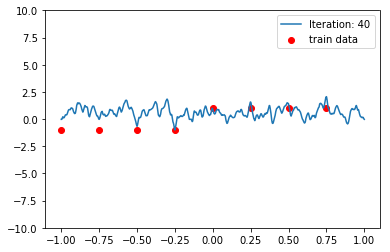

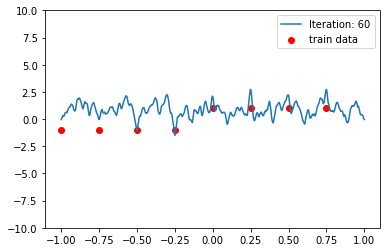

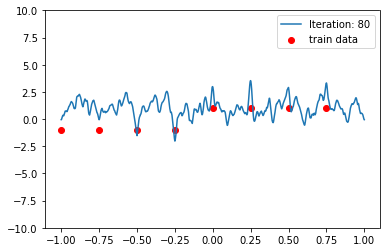

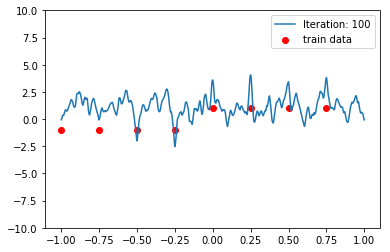

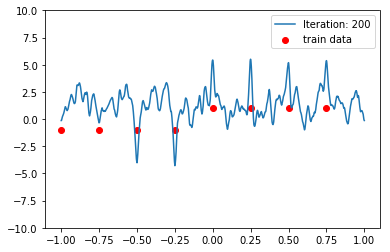

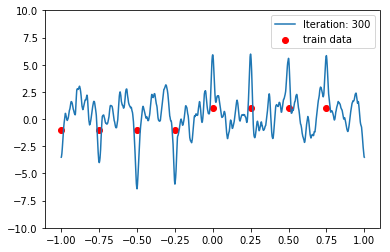

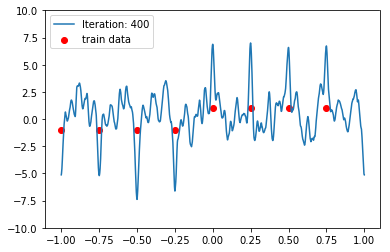

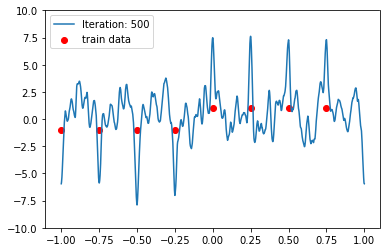

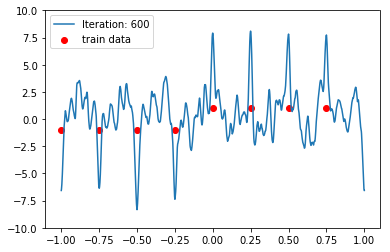

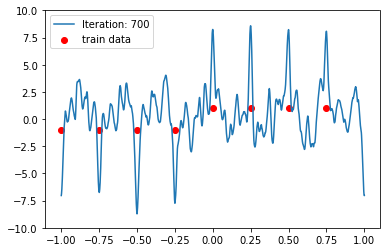

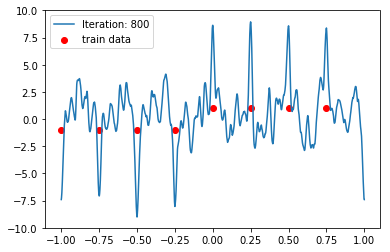

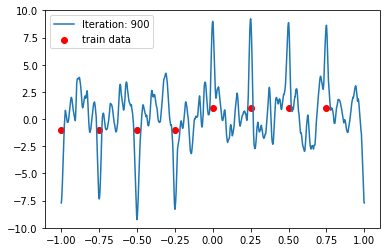

In [33]:
#plt.plot(x_train, y_train_ogi.flatten(),  color = "blue", linewidth=0, marker="D", markersize=5, label = 'Train data', alpha = 0.75 )

for (idx, preds) in enumerate(preds_list_smaller):
    label = "Iteration: " + str(indices[idx])
    plt.scatter(x_train, y_train_ogi, label = 'train data', color = 'red')
    plt.plot(x_test, preds,'-', marker = 'x', markersize = 0, linewidth = 1.5, label = label)
    plt.ylim([-10,10])
    plt.legend()
    plt.show()

# Processing feats and plotting

In [31]:
feats_select = feat_list[-100]

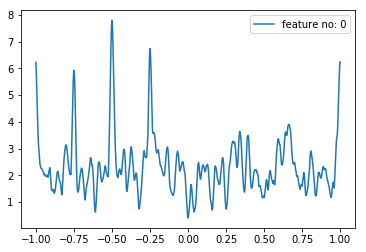

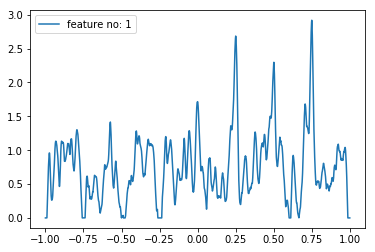

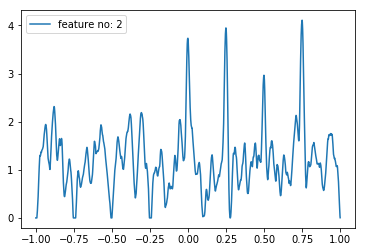

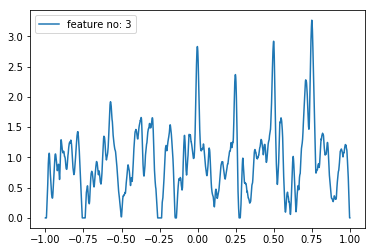

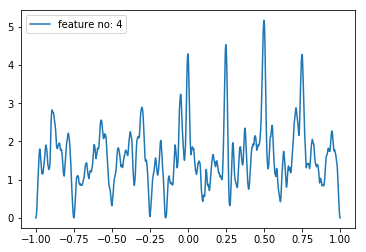

In [32]:
for i in range(5):
    feat_i = feats_select[:, i]
    label = "feature no: " + str(i)
    plt.plot(x_test, feat_i, label = label)
    plt.legend()
    plt.show()